In [1]:
from ioncast import *
from torch.utils.data import DataLoader
import datetime

/home/LinneaWolniewicz/miniforge3/envs/ioncast-physicsnemo/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create sequence dataset
gim_dir = "/home/jupyter/data/jpld/webdataset"
omni_dir = "/home/jupyter/data/omniweb/cleaned"
celestrak_file = "/home/jupyter/data/celestrak/kp_ap_processed_timeseries.csv"
# Create sequence dataset
# gim_dir = "/mnt/disks/disk-main-data-1/data/jpld/webdataset"
# omni_dir = "/mnt/disks/disk-main-data-1/data/omniweb/cleaned"
# celestrak_file = "/mnt/disks/disk-main-data-1/data/celestrak/kp_ap_processed_timeseries.csv"

date_start = None
date_end = None

gim_dataset = JPLDGIMDataset(
    data_dir=gim_dir,
    date_start=date_start,
    date_end=date_end,
)

omni_dataset = OMNIDataset(
    file_dir=omni_dir,
    date_start=date_start,
    date_end=date_end,
)

celestrak_dataset = CelestrakDataset(
    file_name=celestrak_file,
    date_start=date_start,
    date_end=date_end,
)

sequence_dataset = Sequences([gim_dataset, omni_dataset, celestrak_dataset], delta_minutes=15, sequence_length=20)
# sequence_dataset = Sequences([gim_dataset], delta_minutes=15, sequence_length=20)


JPLD
Directory  : /home/jupyter/data/jpld/webdataset
Loading tar files index from cache: /home/jupyter/data/jpld/webdataset/tar_files_index
Start date : 2010-05-13 00:00:00
End date   : 2024-07-31 23:45:00
Delta      : 15 minutes
Loading dates from cache: /home/jupyter/data/jpld/webdataset/dates_index_2010-05-13T00:00:00_2024-07-31T23:45:00
TEC maps total    : 498,623
TEC maps available: 498,481
TEC maps dropped  : 142

OMNIWeb dataset
File                 : /home/jupyter/data/omniweb/cleaned/omni_5min_full_cleaned.csv
Rows                 : 2,103,840


100%|██████████| 2103839/2103839 [15:09<00:00, 2312.54it/s] 


PermissionError: [Errno 13] Permission denied: '/home/jupyter/data/omniweb/cleaned/omni_5min_full_cleaned_deltamin_15_rewind_50.csv'

In [ ]:
# Batch into 5 using a DataLoader
dataloader = DataLoader(
    sequence_dataset,
    batch_size=1,
    shuffle=True,
)

In [ ]:
from ioncast import stack_features

# Iterate through the DataLoader
for batch in dataloader:
    # Print timestamp and features
    print(f"Timestamps: {batch[-1]}")

    timestamps = batch[-1]
    jpld = batch[0]
    omni = batch[1]
    celestrak = batch[2]
    
    stacked_batch = stack_features(batch, model_type="GraphCast_forecast")
    print(stacked_batch)  # Print the stacked features
    print(stacked_batch.shape)  # Print the shape of the stacked features
    print("JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24")

    break

Timestamps: [('2023-04-28T02:00:00',), ('2023-04-28T02:15:00',), ('2023-04-28T02:30:00',), ('2023-04-28T02:45:00',), ('2023-04-28T03:00:00',), ('2023-04-28T03:15:00',), ('2023-04-28T03:30:00',), ('2023-04-28T03:45:00',), ('2023-04-28T04:00:00',), ('2023-04-28T04:15:00',), ('2023-04-28T04:30:00',), ('2023-04-28T04:45:00',), ('2023-04-28T05:00:00',), ('2023-04-28T05:15:00',), ('2023-04-28T05:30:00',), ('2023-04-28T05:45:00',), ('2023-04-28T06:00:00',), ('2023-04-28T06:15:00',), ('2023-04-28T06:30:00',), ('2023-04-28T06:45:00',)]
tensor([[[[ 0.1859,  0.1859,  0.1859,  ...,  0.1859,  0.1859,  0.1859],
          [ 0.2288,  0.2288,  0.2288,  ...,  0.2288,  0.2288,  0.2288],
          [ 0.2784,  0.2784,  0.2784,  ...,  0.2703,  0.2703,  0.2784],
          ...,
          [-0.3669, -0.3813, -0.3813,  ..., -0.3528, -0.3669, -0.3669],
          [-0.4404, -0.4404, -0.4557,  ..., -0.4404, -0.4404, -0.4404],
          [-0.5190, -0.5190, -0.5190,  ..., -0.5190, -0.5190, -0.5190]],

         [[-0.0444

TypeError: Invalid shape (360,) for image data

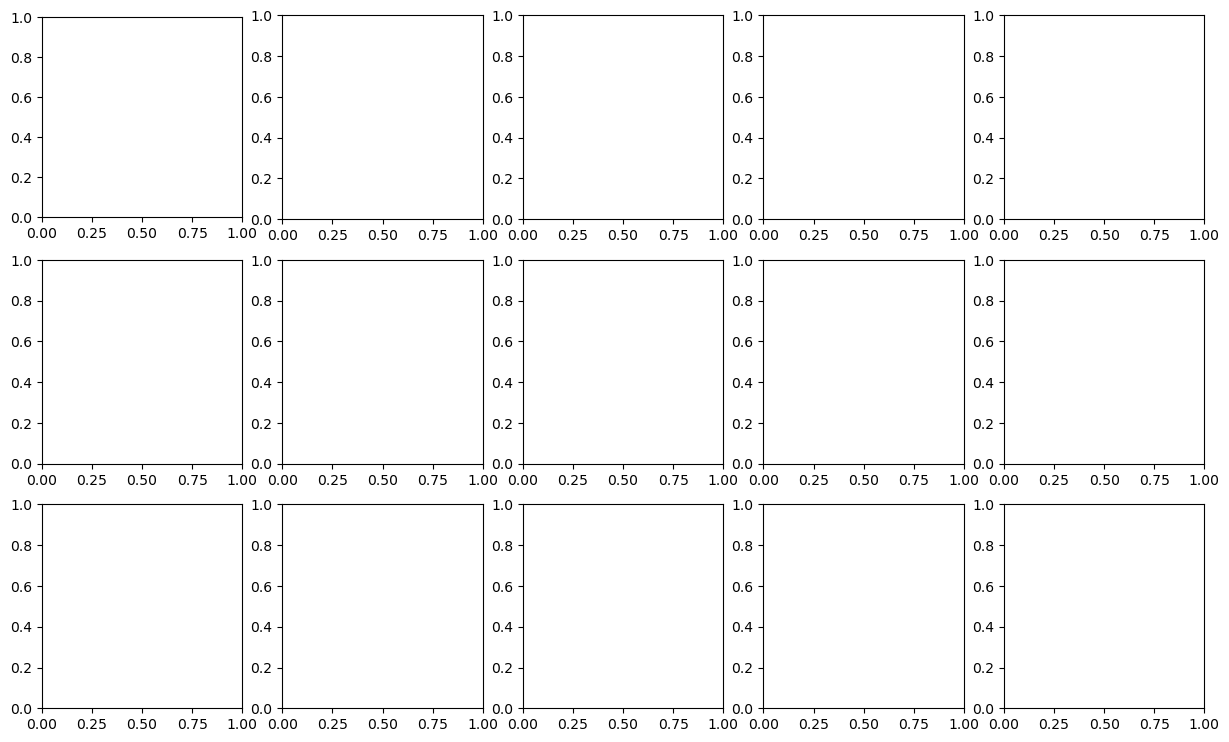

In [ ]:
# Create a 3 x 5 subplot plotting the first feature (vTEC) of the stacked_batch
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
for i in range(3): # Batch
    # first_img = stacked_batch[i, 0, 0].cpu().numpy()  # First feature (vTEC)
    for j in range(5): # Sequence
        feature_idx = 19 # JPLD 0, omni 1-16, celstrak 17-18, subsolar 19, sublunar 20, sin(tod) 21, cos(tod) 22, sin(doy) 23, cos(doy) 24
        seq_idx = j*4

        axs[i, j].imshow(stacked_batch[i, seq_idx, feature_idx].cpu().numpy(), cmap='viridis', clim=(-1, 1))
        axs[i, j].set_title(f"Timestamp {timestamps[seq_idx][i]}", fontsize=8)
        axs[i, j].set_ylabel(f"Batch {i}")
        axs[i, j].set_xlabel(f"Sequence {seq_idx}")
        
        # add colorbar
        plt.colorbar(axs[i, j].images[0], ax=axs[i, j], orientation='vertical', fraction=0.046, pad=0.04)
        

plt.suptitle(f"feature idx {feature_idx}")
plt.tight_layout()
plt.show()

In [ ]:
np.cos(2*np.pi*(6*60 + 45)/(24*60))

np.float64(-0.19509032201612797)